# Statistical and Power Analysis for the Detection of Transcription Errors

## Introduction

- In the simplest scenario, we are comparing two samples, and we wish to decide whether they differ (at a statistically significant level) in the error rate of transcription errors. In each sample, we observe some amount of bases, for which we decide whether or not we consider them to be an error.  
- We may organize our observations in a contingency table as follows:

|   | Sample 1 | Sample 2 |
| ------------- | ------------- | ---|
| **Error bases**  | num_error_1  | num_error_2| 
| **Correct bases**  | num_correct_1  | num_correct_2|

- The data we observed were generated as follows: we sampled *num_observations_1* and *num_observation_2* from samples 1 and 2, and they were distributed between correct and error bases at random, according to error rates *error_rate_1* and *error_rate_2*.
- The error rates consist of two factors: transcription error rates (*tr_error_rate_1* and *tr_error_rate_2*) and *noise_error_rate*. We assume that *tr_error_rate_1* and *tr_error_rate_2* may differ between samples, but the *noise_error_rate* is the same for both samples. We therefore have: 
    - *error_rate_1 = tr_error_rate_1 + noise_error_rate*,
    - *error_rate_2 = tr_error_rate_2 + noise_error_rate* 
    
   Where we omitted the possibility of both transcription error and error from noise occurring at the same time, as the probability of this event is negligibly low.
- The transcription error rates in eukaryotic organisms are of the order $5 \times 10^{-6}$, and the interventions / conditions like aging can increase them $1.5 - 2$ times to $7.5 - 10 \times 10^{-6}$. (see reading notes)
- The *noise_error_rate* is influenced mostly by the error rate of reverse transcription, which is of the order $3-10 \times 10^{-5}$.
- Therefore, the error rates that we are observing will be dominated by the noise errors, and even relatively large increase (e.g. by 50%, from $5 \times 10^{-6}$ to $7.5 \times 10^{-6}$) would require large amount of observation to be detected on statistically significant level. Following plot illustrate this problem - with e.g., 10 millions observed bases in each of the sample, we don't have a much chance to observe statistically significant difference. We would therefore need to observe more bases (say, 100 millions):

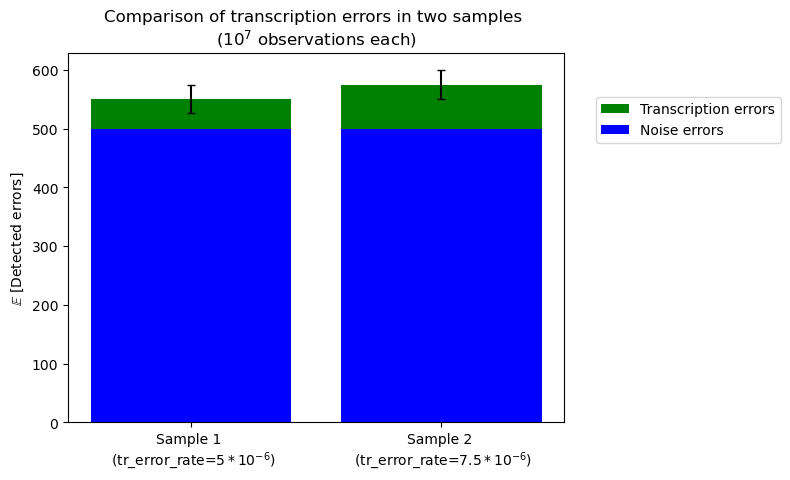

In [1]:
import matplotlib.pyplot as plt
import numpy as np

num_observations = 1 * 1e7
noise_error_rate = 5 * 1e-5
tr_error_rate_1 = 5 * 1e-6
tr_error_rate_2 = 7.5 * 1e-6

std_1 = np.sqrt(num_observations * (tr_error_rate_1 + noise_error_rate) * (1 - tr_error_rate_1 + noise_error_rate))
std_2 = np.sqrt(num_observations * (tr_error_rate_2 + noise_error_rate) * (1 - tr_error_rate_2 + noise_error_rate))

sample_1_name = 'Sample 1 \n (tr_error_rate=$5 * 10^{-6})$'
sample_2_name = 'Sample 2 \n (tr_error_rate=$7.5 * 10^{-6})$'

plt.bar(sample_1_name, num_observations * (tr_error_rate_1 + noise_error_rate),
        color='green', capsize=3, label='Transcription errors', yerr=std_1)
plt.bar(sample_1_name, num_observations * (noise_error_rate), color='blue', label='Noise errors')

plt.bar(sample_2_name, num_observations * (tr_error_rate_2 + noise_error_rate),
        color='green', capsize=3, yerr=std_2)
plt.bar(sample_2_name, num_observations * (noise_error_rate), color='blue')

plt.ylabel('$\mathbb{E}$ [Detected errors]')
plt.title('Comparison of transcription errors in two samples \n'+r'($10^7$ observations each)')
ax = plt.gca()
plt.legend(bbox_to_anchor=(1.05, 0.9), bbox_transform=ax.transAxes)
plt.show()

## $\chi^2$ Test for Contingency Table
- The straightforward way to test for a difference in observed error rates between 2 samples in by the [Chi-squared test](https://en.wikipedia.org/wiki/Chi-squared_test). The null hypothesis $H_0$ states that the row distribution (error vs correct bases) and column distribution (Sample 1 vs Sample 2) are independent of each other.
- Esentially, the $\chi^2$ test is a test of goodness-of-fit for a multinomial distirbution. Given a multinomial distribution and set of observations, we can use it to test whether the observed values arised from a given multinomial distribution. 
- When applied to our setting with observations in a contingency table, the testing consist of 2 steps. First, we estimate the expected number of observed values in each cell of the table, assuming $H_0$ holds true (i.e. error rate is independent on sample, meaning it's the same in Sample 1 and Sample 2). As a second step, we use $\chi^2$ test as a godness-of-fit between the values expected under $H_0$ and values that were observed in the experiment.
- Under the $H_0$, the test statistic is distributed according to a $\chi^2$ distribution. Given a threshold on statistical significance (e.g, $\alpha = 0.05$), the critical value is then given as a $(1-\alpha)$ quantile of that distribution:

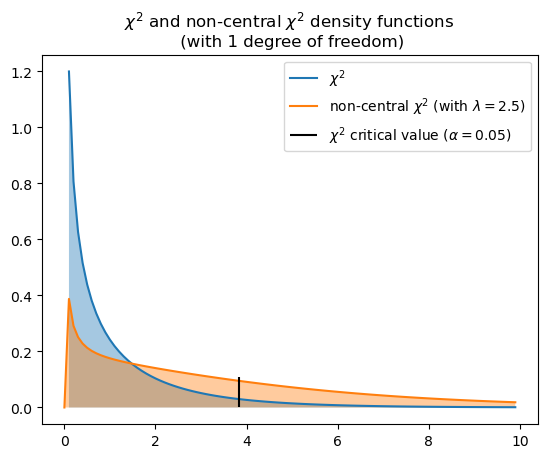

In [2]:
from scipy.stats import chi2, ncx2

x = np.arange(0, 10, 0.1)
y_chi2 = chi2.pdf(x, df=1)
lambda_parameter = 2.5
y_chi2_noncentral = ncx2.pdf(x, df=1, nc=lambda_parameter)

alpha = 0.05
critical_value = chi2.ppf(1 - alpha, df=1)

plt.plot(x, y_chi2, label = r'$\chi^2$')
plt.fill_between(x, y_chi2, alpha=0.4)

plt.plot(x, y_chi2_noncentral, label = fr'non-central $\chi^2$ (with $\lambda={lambda_parameter}$)')
plt.fill_between(x, y_chi2_noncentral, alpha=0.4)

plt.vlines(x=critical_value, color='black', ymin=0, ymax=0.11, label=fr'$\chi^2$ critical value ($\alpha={alpha}$)')
plt.title("$\chi^2$ and non-central $\chi^2$ density functions \n (with 1 degree of freedom)")
plt.legend()
plt.show()

## Power Analysis for $\chi^2$ Test
- If the error rates differ between samples, the $H_0$ does not holds. The test statistics is then distributed according to the [Noncentral $\chi^2$ distribution](https://en.wikipedia.org/wiki/Noncentral_chi-squared_distribution). Therefore, the test statistics has a higher probability to exceed the critical value (which is computed as a quantile of the $\chi^2$ distribution) than $\alpha$. We would like to compute this probability (assuming the values of error rates and the number of observations) to determine the power of the test.
- Instead of figuring the formula for a parameters of non-central $\chi^2$ given the error rates and number of observations, I decided for a simulation approach: generate an artificial samples and perform the statistical testing on them (using *scipy.stats.chi2_contingency* function). We then simply record the fraction of experiments that lead to a rejection of $H_0$.
- Folowing code prepares a few helpful classes and functions: 

In [3]:
from dataclasses import dataclass
from scipy.stats import chi2_contingency
from scipy.stats.contingency import Chi2ContingencyResult
from tqdm import trange
import torch


@dataclass
class Sample:
    num_errors: int
    num_correct: int


@dataclass
class ExperimentCHi2:
    sample_1: Sample
    sample_2: Sample
    contingency_table: np.array
    test_result: Chi2ContingencyResult


def generate_sample(num_observations: int, error_rate: float, use_gpu=True) -> Sample:
    remains_to_generate = num_observations
    batch_size = int(1e6)
    num_errors = 0
    while remains_to_generate > batch_size:
        if use_gpu:
            num_errors += torch.sum(torch.rand(int(batch_size), device='cuda') < error_rate).cpu().numpy()
        else:
            num_errors += np.sum(np.random.random(batch_size) < error_rate)
        remains_to_generate -= batch_size
    if use_gpu:
        num_errors += torch.sum(torch.rand(int(remains_to_generate), device='cuda') < error_rate).cpu().numpy()
    else:
        num_errors += np.sum(np.random.random(remains_to_generate) < error_rate)
    return Sample(num_errors=num_errors, num_correct=num_observations - num_errors)


def run_experiments(tr_error_rate_1: float,
                    tr_error_rate_2: float,
                    noise_error_rate: float,
                    num_observations_1: int,
                    num_observations_2: int,
                    num_experiments=1000,
                    ) -> list[ExperimentCHi2]:
    num_experiments = int(1e3)
    experiments: list[ExperimentCHi2] = []
    for _ in trange(num_experiments, desc='Running experiments'):
        sample_1 = generate_sample(num_observations_1, noise_error_rate + tr_error_rate_1)
        sample_2 = generate_sample(num_observations_2, noise_error_rate + tr_error_rate_2)
        contingency_table = np.asarray([[sample_1.num_errors, sample_2.num_errors],
                                        [sample_1.num_correct, sample_2.num_correct]])
        experiments.append(ExperimentCHi2(sample_1=sample_1,
                                          sample_2=sample_2,
                                          contingency_table=contingency_table,
                                          test_result=chi2_contingency(contingency_table)))
    return experiments

- Given the specification of the relevant parameters (tr_error_rate_1, tr_error_rate_2, noise_error_rate, num_observations_1 and num_observations_2), we can run artificial experiments and use them to estimate the power of the $\chi^2$ test (for any level of $\alpha$):

Running experiments: 100%|█████████████████| 1000/1000 [00:03<00:00, 313.51it/s]


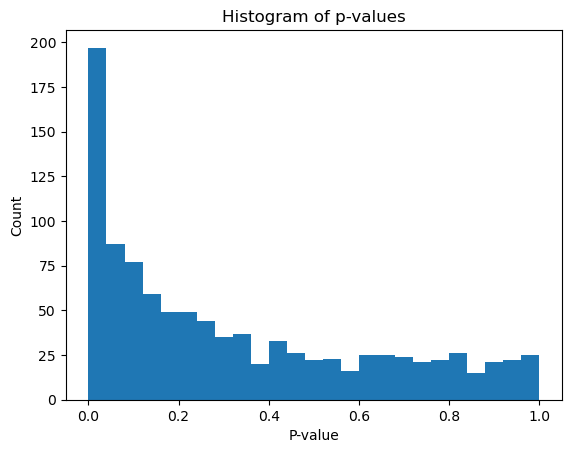

Estimated power (alpha=0.05): 0.222
Estimated power (alpha=0.01): 0.09


In [4]:
experiments = run_experiments(tr_error_rate_1=5 * 1e-6,
                              tr_error_rate_2=7.5 * 1e-6,
                              noise_error_rate=5 * 1e-5,
                              num_observations_1=3 * 1e7,
                              num_observations_2=3 * 1e7)

plt.hist([x.test_result.pvalue for x in experiments], bins=25)
plt.title('Histogram of p-values')
plt.xlabel('P-value')
plt.ylabel('Count')
plt.show()

print(f"Estimated power (alpha=0.05): {sum([x.test_result.pvalue <= 0.05 for x in experiments]) / len(experiments)}")
print(f"Estimated power (alpha=0.01): {sum([x.test_result.pvalue <= 0.01 for x in experiments]) / len(experiments)}")


- As the power of the test depends on multiple paramaters, we will fix all except one of them, which we will systematically vary, and then plot the power of the test as a function of that varying parameter. We can plot the power of the test versus the amount of observations:

Running experiments: 100%|██████████████████| 1000/1000 [00:48<00:00, 20.57it/s]


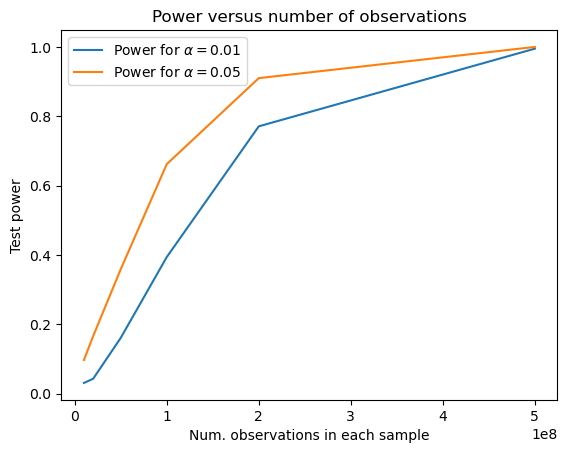

In [5]:
num_observations_in_experiment = [1e7, 2 * 1e7, 5 * 1e7, 1e8, 2 * 1e8, 5 * 1e8]
power_01 = []
power_05 = []
for num_observations in num_observations_in_experiment:
    experiments = run_experiments(tr_error_rate_1=5 * 1e-6,
                                  tr_error_rate_2=7.5 * 1e-6,
                                  noise_error_rate=5 * 1e-5,
                                  num_observations_1=num_observations,
                                  num_observations_2=num_observations)
    power_01.append(sum([x.test_result.pvalue <= 0.01 for x in experiments]) / len(experiments))
    power_05.append(sum([x.test_result.pvalue <= 0.05 for x in experiments]) / len(experiments))

plt.plot(num_observations_in_experiment, power_01, label=r'Power for $\alpha=0.01$')
plt.plot(num_observations_in_experiment, power_05, label=r'Power for $\alpha=0.05$')
plt.title(f"Power versus number of observations")
plt.ylabel("Test power")
plt.xlabel("Num. observations in each sample")
plt.legend()
plt.show()

- The power of the test also depends on the difference in error rates. Large differences are more likely to be detected as statistically significant:

Running experiments: 100%|█████████████████| 1000/1000 [00:09<00:00, 101.47it/s]


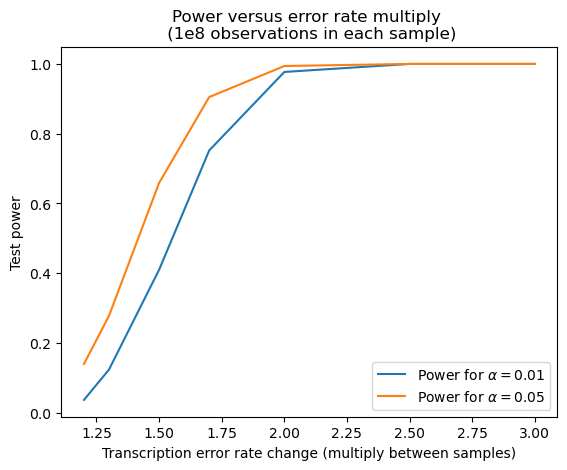

In [6]:
tr_error_rate_1 = 5 * 1e-6
tr_error_rate_2_multiply = [1.2, 1.3, 1.5, 1.7, 2, 2.5, 3.0]

power_01 = []
power_05 = []
for tr_error_rate_multiply in tr_error_rate_2_multiply:
    experiments = run_experiments(tr_error_rate_1=5 * 1e-6,
                                  tr_error_rate_2=tr_error_rate_1 * tr_error_rate_multiply,
                                  noise_error_rate=5 * 1e-5,
                                  num_observations_1=1e8,
                                  num_observations_2=1e8)

    power_01.append(sum([x.test_result.pvalue <= 0.01 for x in experiments]) / len(experiments))
    power_05.append(sum([x.test_result.pvalue <= 0.05 for x in experiments]) / len(experiments))

plt.plot(tr_error_rate_2_multiply, power_01, label=r'Power for $\alpha=0.01$')
plt.plot(tr_error_rate_2_multiply, power_05, label=r'Power for $\alpha=0.05$')
plt.title(f"Power versus error rate multiply \n (1e8 observations in each sample)")
plt.ylabel("Test power")
plt.xlabel("Transcription error rate change (multiply between samples)")
plt.legend()
plt.show()

- Also, higher level of noise makes it harder to detect the difference in transcriptional error rate:

Running experiments: 100%|█████████████████| 1000/1000 [00:09<00:00, 100.94it/s]


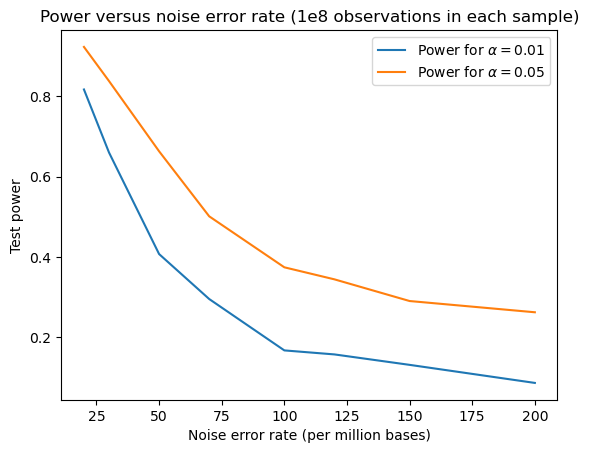

In [7]:
noise_error_rate_per_million_bases = [20, 30, 50, 70, 100, 120, 150, 200]

power_01 = []
power_05 = []
for noise_error_rate in noise_error_rate_per_million_bases:
    experiments = run_experiments(tr_error_rate_1=5 * 1e-6,
                                  tr_error_rate_2=7.5 * 1e-6,
                                  noise_error_rate=noise_error_rate * 1e-6,
                                  num_observations_1=1e8,
                                  num_observations_2=1e8)

    power_01.append(sum([x.test_result.pvalue <= 0.01 for x in experiments]) / len(experiments))
    power_05.append(sum([x.test_result.pvalue <= 0.05 for x in experiments]) / len(experiments))

plt.plot(noise_error_rate_per_million_bases, power_01, label=r'Power for $\alpha=0.01$')
plt.plot(noise_error_rate_per_million_bases, power_05, label=r'Power for $\alpha=0.05$')
plt.title(f"Power versus noise error rate (1e8 observations in each sample)")
plt.ylabel("Test power")
plt.xlabel("Noise error rate (per million bases)")
plt.legend()
plt.show()